In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"           
import scipy.io as sio
import sys                                                                              
import h5py as hp
import argparse
import random           
import numpy as np
import cv2
from random import choices, choice
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from IPython.display import HTML, display, Image
from numpy.fft import ifft2,fft2,fft,ifft,fftfreq, fftshift,ifftshift

from IPython.display import HTML, display, Image
import time
from tqdm.auto import tqdm
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import convolve2d, correlate2d
from scipy.optimize import curve_fit
import scipy 

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from tifffile import imread
from torchsummary import summary
from torch.nn.utils import spectral_norm
import itertools


def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def rebin1d(arr, new_shape):
    shape = (new_shape, arr.shape[0] // new_shape)
    return arr.reshape(shape).mean(-1)

def normalize(x):
    return (x-np.amin(x))/(np.amax(x)-np.amin(x))#x/np.amax(x)#
def normalize_t(x):
    return (x-torch.amin(x))/(torch.amax(x)-torch.amin(x))#x/np.amax(x)#


def centralpadding(arr, new_shape):
    if new_shape[0]>=arr.shape[0]:
        newarr = np.zeros(new_shape,dtype=complex)
        newarr[(new_shape[0] - arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (new_shape[1] - arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ] = arr
    else:
        newarr= arr[(-new_shape[0] + arr.shape[0]) //2 : (new_shape[0] + arr.shape[0]) //2 ,
               (-new_shape[1] + arr.shape[1]) //2 : (new_shape[1] + arr.shape[1]) //2 ]
    return newarr

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile

def moving_average_smooth(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec
def autocor2d(I):
    f = fft2(I)
    f = np.absolute(f)**2
    autocor2d = ifftshift(ifft2(f))/I.shape[0]/I.shape[1]
    return autocor2d
def autocor2d_t(I):
#     f = torch.absolute(torch.fft.fft2(I))**2

#     autocor2d = torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2))/I.shape[0]/I.shape[1]
    return  torch.fft.ifftshift(torch.fft.ifft2( torch.absolute(torch.fft.fft2(I))**2),dim=(-2,-1))/I.shape[-1]/I.shape[-2]

def axis1norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        Y[i,:] = X[i,:]/np.mean(X[i,:]**1)
    return Y

def axis0norm(X):
    Y=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Y[:,i] = X[:,i]/np.mean(X[:,i]) 
    return Y

def ReLU(x):
    return x * (x > 0)
#load exp data

filename = [#one interval
#             "../expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153S_KCl_below106_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153L_KCl_106-180_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153A_KCl_180-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153B_KCl_250-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153D_KCl_355-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153E_KCl_425-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153I_KCl_above500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #two interval
            "expdata/mesh_1_220710/220710_153P_KCl_106-250_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153K_KCl_180-300_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153F_KCl_250-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153G_KCl_300-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153M_KCl_355-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #three interval
            "expdata/mesh_1_220710/220710_153N_KCl_180-355_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153T_KCl_250-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153R_KCl_355-1000_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #four interval
            "expdata/mesh_1_220710/220710_153Q_KCl_180-425_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
            "expdata/mesh_1_220710/220710_153O_KCl_250-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",
    #five interval
            "expdata/mesh_1_220710/220710_153H_KCl_180-500_500frame_200us_0ms_180GAN_bin2.npz_auto.npz",    
            ]
basefilename =  "expdata/mesh_1_220710/220710_153Z_MCC_less45_500frame_200us_0ms_180GAN_bin2.npz_auto.npz"
basename = '<45 um'            
name = [#one interval
#         '<45 μm',
        '0-106 um',
        '106-180 um',
        '180-250 um',
        '250-300 um',
#         '300-355 μm',
        '355-425 um',
        '425-500 um',
        '500-1000 um',
        #two interval
        '106-250 um',
        '180-300 um',
        '250-355 um',
        '300-425 um',
        '355-500 um',
        #three interval
        '180-355 um',
        '250-425 um',
        '355-1000 um',
        #four interval
        '180-425 um',
        '250-500 um',
        #five interval
        '180-500 um']

# 

# 1 Load raw pupil


In [3]:
def g_loss_npcc(generated_image, true_image):
    fsp=generated_image-np.mean(generated_image,axis=(0,1))
    fst=true_image-np.mean(true_image,axis=(0,1))
    
    devP=np.std(generated_image,axis=(0,1))
    devT=np.std(true_image,axis=(0,1))
    
    npcc_loss=(-1)*np.mean(fsp*fst,axis=(0,1))/np.clip(devP*devT,1e-10,None)    ## (BL,1)
    return npcc_loss
    
    
    
pupil_filename = 'expdata/raw_pupil/mesh_1_bin1_rotate90_MMStack_Default.ome.tif'
# pupil_filename = '../expdata/raw_pupil/circle_original_bin1_MMStack_Default.ome.tif'
                                        
pupil = imread(pupil_filename)[0:2600,0:2600]/2**16  #16-bit pixel type. Normalize its maximum to 1
pupil = np.abs(centralpadding(pupil,(4096,4096)))
print(np.amax(pupil))                                    
print(pupil.shape)

# mccdata = np.load(filename[1])
# mccauto = mccdata['auto'][:,128-48:128+48, 128-48:128+48] #crop them into 64 x 64
# print(mccauto.shape)
# mccauto_mean = np.mean(np.abs(mccauto[100:300]),axis=0)**0.125

(h, w) = pupil.shape[:2]
center = (w / 2, h / 2)
angle = 61.039  #optimized with npcc loss
scale = 1
padding = 10936 #optimized with npcc loss

M = cv2.getRotationMatrix2D(center, angle, scale)
rotated_pupil = cv2.warpAffine(pupil, M, (w, h))
psd_pupil = normalize(np.abs( centralpadding(  np.abs(fftshift(fft2(rotated_pupil,(padding,padding)))) ,(96,96)) ))
psd_pupil = psd_pupil/np.amax(psd_pupil)




0.99951171875
(4096, 4096)


sum of engineered pupil is  3217.722508815117
0.35050730662428115


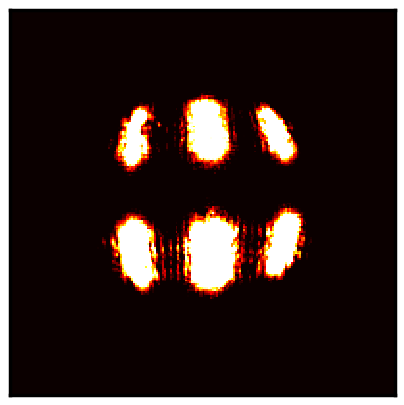

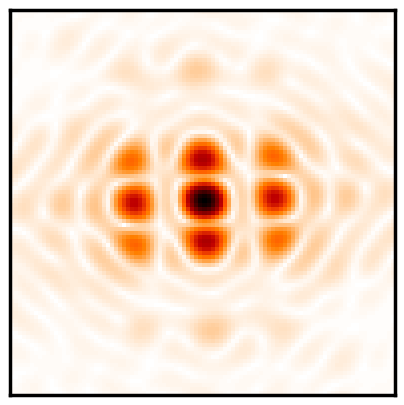

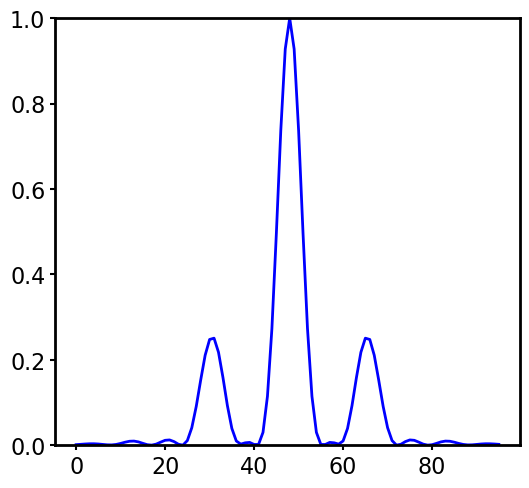

In [4]:
plt.figure(figsize=(5,5),facecolor='white')
# plt.pcolormesh(np.abs(rebin(rotated_pupil,(256,256)))[50:250,22:222],  
#                 cmap=plt.cm.hot,vmin=0.1,vmax=0.5)
plt.pcolormesh(np.abs(rebin(rotated_pupil,(256,256)))[43:243,22:222],  
                cmap=plt.cm.hot,vmin=0.1,vmax=0.5)
# plt.colorbar()
plt.gca().set_aspect('equal')
# plt.title("up:measurement; down:calculation @ " + name[plot_idx])
# plt.axis('off')
plt.xticks([])    
plt.yticks([])
[x.set_linewidth(2.5) for x in plt.gca().spines.values()]

print("sum of engineered pupil is ",np.sum(np.abs(rebin(rotated_pupil,(256,256)))[43:243,22:222]))

plt.figure(figsize=(5,5),facecolor='white')
plt.pcolormesh(psd_pupil**1,  
                cmap=plt.cm.gist_heat_r,vmin=0.)
# plt.colorbar()
plt.gca().set_aspect('equal')
# plt.xlim(43,54)
# plt.ylim(43,54)
# plt.title("up:measurement; down:calculation @ " + name[plot_idx])
# plt.axis('off')
plt.xticks([])    
plt.yticks([])
[x.set_linewidth(2.5) for x in plt.gca().spines.values()]


plt.figure(facecolor='w',figsize=(6,6))
plt.plot(psd_pupil[48,:]**2,linewidth=2,
         color='blue',label='round')
# plt.legend(prop={'size': 12})
# plt.xlim(-128,128)
plt.ylim(-0.00,1)
plt.tick_params(labelsize=16,width=1.5)
# plt.xlabel('Pixel',fontdict=font)
plt.gca().set_aspect(96/1)
[x.set_linewidth(2) for x in plt.gca().spines.values()]



print(np.sum(psd_pupil[43:54,43:54]**2) / np.sum(psd_pupil**2))



In [5]:
print("round pupil",10000*(1-0.873))
print("engineered pupil",3200*(1-0.3506))

round pupil 1270.0
engineered pupil 2078.08


# 2_Prepare the measured PSD curves

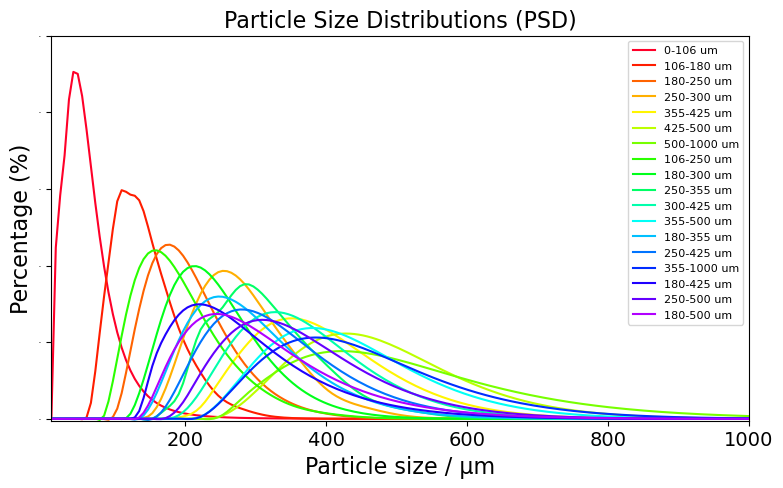

In [6]:
x_exp = np.array([5.052721,5.708679, 6.449795, 7.287125, 8.233159, 9.30201, 10.509622, 11.87401, 13.415526, 15.157166, 17.12491, 19.348112, 21.859937, 24.697853, 27.904195, 31.526793, 35.619687, 40.243931, 45.468507, 51.371,58.041,65.575 ,74.089 ,83.707 ,94.574 ,106.852 ,120.724 ,136.397 ,154.104 ,174.11 ,196.714 ,222.251 ,251.105 ,283.704 ,320.535 ,362.148 ,409.163 ,462.281 ,522.296 ,590.102  ,666.711 ,753.265 ,851.056,961.542 ,1086.372 ,1227.408,1386.753,1566.785,1770.189236,2000])
y_exp = np.zeros((18,50))
cumul_exp = np.zeros((18,50,192))
PSD_exp = np.zeros((18,50,192))
#0-106
y_exp[0] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.329, 0.354806, 0.42184, 0.568075, 0.833946, 1.260692, 1.877542, 2.692323, 3.683046, 4.798908, 5.931844, 6.965192, 7.77498, 8.252806, 8.329522, 7.991714, 7.29672, 6.354712, 5.295245, 4.244794, 3.300247, 2.510142, 1.886694, 1.409925, 1.043594, 0.756199, 0.526933, 0.343952, 0.206219, 0.111196, 0.048481, 0.042145, 0, 0, 0, 0, 0, 0., 0., 0.])
#106-180
y_exp[1] = np.array([0, 0, 0, 0, 0, 0 ,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.105737, 0.607724, 1.689872, 3.549482, 6.407332, 8.947484, 12.13407, 13.768389, 14.101525, 12.709704, 10.320739, 6.625226, 4.228251, 1.767543, 0.454671 ,0.024362, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#180-250
y_exp[2] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.264188,1.32076,3.404871,6.55305,10.289939,13.687966,15.681095,15.560933,13.359631,9.807277,6.016891,2.934334,0.987611,0.131455,0,0,0,0,0,0,0,0,0,0,0])
#250-300
y_exp[3] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011301,0.149071,1.135828,3.784526,8.453529,14.154435,18.461199,19.313686,16.465771,9.96075,5.90831,1.775483,0.408165,0.017945,0,0,0,0,0,0,0,0,0])
# #300-355
# y_exp[4] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.044741,0.504016,2.284134,5.989601,11.328636,16.607,19.33342,18.04342,13.479621,7.853114,3.416383,1.00165,0.114255,0,0,0,0,0,0,0,0])            
#355-425
y_exp[4] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056623,0.431226,2.026036,5.100005,9.680166,14.558908,17.802229,17.926852,14.828766,9.931996,5.222166,2.023594,0.38209,0.029343,0,0,0,0,0,0])
#425-500
y_exp[5] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.097102,0.853006,2.942142,6.89088,12.153087,16.916801,19.000207,17.257351,12.580986,7.229044,3.1366,0.82044,0.122351,0,0,0,0,0])
#500-1000
y_exp[6] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08657, 0.928598, 2.521839, 5.002722, 8.085392, 11.187501, 13.560781, 14.523372, 13.788833, 11.590841, 8.572679, 5.491205, 2.955525, 1.277095, 0.384978, 0.04207, 0, 0])

#106-250
y_exp[7] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.013082, 0.32778, 1.166862, 2.691772, 4.897376, 7.574823, 10.287747, 12.449715, 13.53849, 13.167671, 11.581957, 8.970119, 5.871621, 3.570353, 1.451356, 0.348614, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#180-300
y_exp[8] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.054641,0.633828,2.179623,5.034658,9.000704,13.159835,16.123753,16.759201,14.781634,10.970811,6.732472,3.258536,1.11493,0.195374,0,0,0,0,0,0,0,0,0,0])
#250-355
y_exp[9] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00762,0.294163,1.365135,4.963453,8.634741,15.08414,18.578039,18.696791,15.696254,9.243654,5.380616,1.693197,0.340799,0.021397,0,0,0,0,0,0,0,0])
#300-425
y_exp[10] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182731,1.12844,3.466986,7.40465,12.29058,16.486726,18.152366,16.519571,12.322213,7.391204,3.42017,1.092874,0.14149,0,0,0,0,0,0,0])
#355-500
y_exp[11] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.065509,0.77352,2.705588,6.219485,10.882955,15.300683,17.751673,17.138357,13.704979,8.937054,4.576775,1.663249,0.280174,0,0,0,0,0,0])

#180-355
y_exp[12] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011667, 0.383033, 1.539086, 3.75342, 6.970283, 10.629793, 13.79966, 15.521836, 15.191959, 12.923254, 9.46028, 5.810313, 2.867772, 1.019459, 0.118186, 0, 0, 0, 0, 0, 0, 0, 0])
#250-425
y_exp[13] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.343618, 1.493119, 3.74539, 7.025048, 10.741106, 13.955666, 15.650635, 15.249357, 12.897479, 9.359246, 5.705749, 2.777114, 0.953633, 0.102839, 0, 0, 0, 0, 0, 0, 0])
# #300-500
# y_exp[14]= np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.287173, 1.462291, 3.724655, 7.046573, 10.840323, 14.109045, 15.804788, 15.355046, 12.902635, 9.285513, 5.587847, 2.662302, 0.845675, 0.086133, 0, 0, 0, 0, 0, 0])
#355-1000
y_exp[14] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.054247,0.671347,2.279459,5.068086,8.781545,12.588202,15.359278,16.132974,14.604475,11.324831,7.404821,3.918373,1.512548,0.299813,0,0,0,0,0])

#180-425
y_exp[15]= np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.166823,1.189156,2.673891,4.718039,7.097056,9.442082,11.356635,12.478271,12.572566,11.616038,9.795376,7.460738,5.042378,2.894559,1.299418,0.196975,0,0,0,0,0,0,0])
#250-500
y_exp[16] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.024526,0.46146,1.843826,4.288512,7.691249,11.388998,14.384385,15.717581,14.945787,12.316661,8.698389,5.124577,2.36795,0.697196,0.048901,0,0,0,0,0,0])

#180-500
y_exp[17] = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.,0.,0.,0.,0,0,0,0,0.031088,0.428629,1.432848,3.072516,5.290804,7.824863,10.247307,12.093036,12.95407,12.633338,11.202154,8.971138,6.420329,4.006585,2.070191,0.742212,0.088609,0,0,0,0,0,0])




x_new = np.linspace(10, 1200, num=192, endpoint=True)
for i in range(18):
    f = interp1d(x_exp, y_exp[i],kind='cubic')    
    for j in range(50):
        psd = f(x_new)
        psd = psd/(np.arange(192)+3)**3 #from the volume size distribution to particle number size distribution (1/r^3)
        cumul_exp[i,j]=np.flip(np.cumsum(np.flip(psd))) #calculate the cumulative distribution
        cumul_exp[i,j]=cumul_exp[i,j]/cumul_exp[i,j,0] #normalize it to 0-1
        PSD_exp[i,j] = psd/np.sum(psd) #normalize the PSD
 

    
#     plt.figure()
#     plt.bar(x_new, psd/np.amax(psd),fill=True,width=8, 
#                  color='orange',label='distribution')
#     plt.plot(x_new, cumul_exp[i,-1],label='cumul_noisy')#,label = name[i])
# #     plt.plot(x_new, np.flip(np.cumsum(np.flip(f(x_new)/np.sum(f(x_new))))),'r--',label='cumul_smooth')#,label = name[i])
#     plt.title(name[i])
    
#     plt.legend(loc='best')

# print(y_exp.shape)


cmap = plt.get_cmap('gist_rainbow')
colors = [cmap(i) for i in np.linspace(0, 1,20)]
plt.figure(figsize=(9,5),facecolor='w')

j=0
for i in range(18):
    plt.plot(x_new, PSD_exp[i,0],color=colors[i],label=name[i]) 

plt.xlim(10,1000)
plt.ylim(-0.0005,0.1)
plt.xlabel('Particle size / μm',fontsize=16)
plt.ylabel('Percentage (%)',fontsize=16)
plt.title("Particle Size Distributions (PSD)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=0)
# plt.xscale("log")
plt.legend(prop={'size': 8})

Text(0.5, 1.0, '180-500 um')

<Figure size 900x500 with 0 Axes>

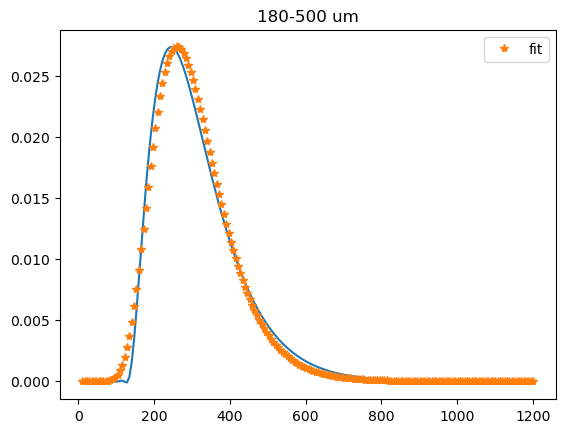

In [7]:
def lognormal(x,mu,sigma):
    return 1/x/sigma/np.sqrt(2*np.pi)* np.exp( -(np.log(x)-mu)**2/2/sigma**2 )

cmap = plt.get_cmap('gist_rainbow')
colors = [cmap(i) for i in np.linspace(0, 1,20)]
plt.figure(figsize=(9,5))

idx = 17#     fit_para[idx], covariance = curve_fit(lognormal, x_new, PSD_exp[idx,0])

#     fit_y = lognormal(x_new,fit_para[idx,0], fit_para[idx,1])#,fit_para[idx,2])#, fit_a3, fit_sigma3)
fit_y = lognormal(x_new,5.67, 0.33)#,fit_para[idx,2])#, fit_a3, fit_sigma3)
fit_y = fit_y/np.sum(fit_y)
plt.figure(facecolor='w')
plt.plot(x_new, PSD_exp[idx,0])
plt.plot(x_new, fit_y, '*', label='fit')
# plt.ylim(0,1)
plt.legend()
plt.title(name[idx])

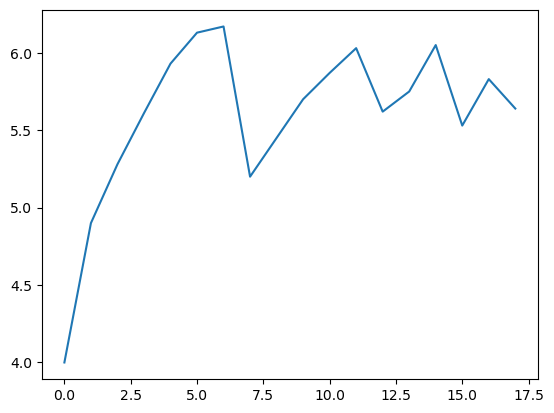

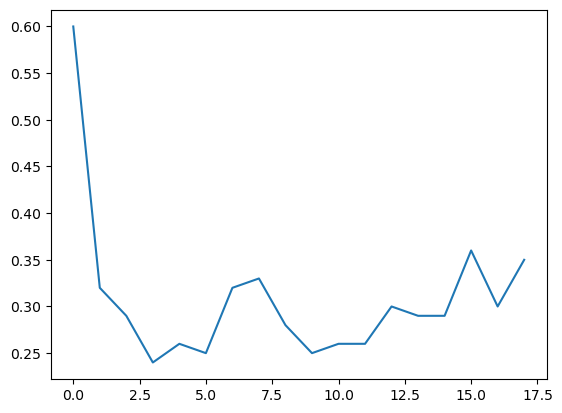

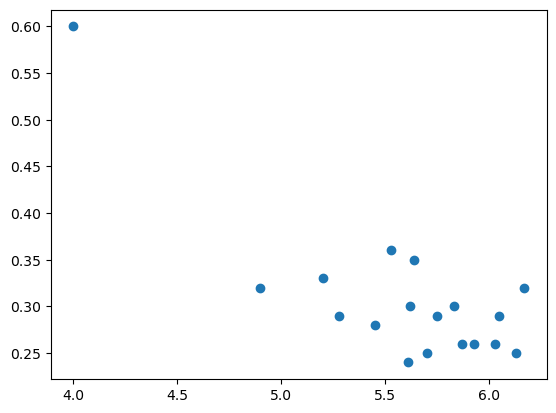

In [8]:
fit_para = np.zeros((18,2))

fit_para[0,0] = 4#-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[0,1] = 0.6

fit_para[1,0] = 4.9  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[1,1] = 0.32

fit_para[2,0] = 5.28  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[2,1] = 0.29

fit_para[3,0] = 5.61  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[3,1] = 0.24

fit_para[4,0] = 5.93  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[4,1] = 0.26

fit_para[5,0] = 6.13  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[5,1] = 0.25

fit_para[6,0] = 6.17  #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[6,1] = 0.32

fit_para[7,0] = 5.2 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[7,1] = 0.33

fit_para[8,0] = 5.45 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[8,1] = 0.28

fit_para[9,0] = 5.7 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[9,1] = 0.25

fit_para[10,0] = 5.87 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[10,1] = 0.26

fit_para[11,0] = 6.03 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[11,1] = 0.26

fit_para[12,0] = 5.62 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[12,1] = 0.3

fit_para[13,0] = 5.75 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[13,1] = 0.29

fit_para[14,0] = 6.05 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[14,1] = 0.29

fit_para[15,0] = 5.53 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[15,1] = 0.36

fit_para[16,0] = 5.83 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[16,1] = 0.3

fit_para[17,0] = 5.64 #-0.2641492917433854#-0.466#-0.7537285658936798
fit_para[17,1] = 0.35
plt.figure(facecolor='w')
plt.plot(fit_para[:,0])
plt.figure(facecolor='w')
plt.plot(fit_para[:,1])
plt.figure(facecolor='w')
plt.scatter((fit_para[:,0]),(fit_para[:,1]))


# 3_Prepare the calculations from the forward model

In [9]:


#### important parameter #####
#can be calculated from the parameters in the optics, or fit from the side lobe positions. 
#There two methods gives the a close D value.
D=1.49 * 2/3 #4800um is the beam spot size*
d = D/4800*1200
d_start = d/1200*10

# print(d)
# print(d/psd_pixel)
##############################

x = np.arange(-48, 48, 1)
y = np.arange(-48, 48, 1)
xx, yy = np.meshgrid(x, y, sparse=True)
u = np.sqrt(xx**2 + yy**2)


##############################

delta = 0.000001
psd_pixel = 192

H = np.zeros((96,96,psd_pixel)) #psd_pixel x height x width
Hs = np.zeros((96,96,psd_pixel)) #psd_pixel x height x width

r = np.linspace(d_start, d, psd_pixel)

for i in range(H.shape[-1]):
    Hs[:,:,i] = np.sin(r[i]*(u+delta)) /(u+delta)#/(r[i]+delta)
    H[:,:,i] = r[i]*scipy.special.jv(1, r[i]*(u+delta)) /(u+delta)#/(r[i]+delta)
##############################


In [259]:
#Generate the synthetic dataest

#beta distributions
def lognormal(x,mu,sigma):
    return 1/x/sigma/np.sqrt(2*np.pi)* np.exp( -(np.log(x)-mu)**2/2/sigma**2 )

S = 500
Nd = 192

auto_sim = np.zeros((18,S,96,96))
PSD_sim = np.zeros((18,S,Nd))
cumul_sim = np.zeros((18,S,Nd))
u_sim = np.zeros((18,S))
s_sim = np.zeros((18,S))

for t in range(18):

#     mean = (fit_para[2*t,0], fit_para[2*t,1])
    mean = (fit_para[t,0], fit_para[t,1])
    r = 0.005
    cov = [[r, 0], [0, r/2.5*0.25]]
    generated_us = np.random.multivariate_normal(mean, cov, (S))
    
    for i in tqdm(range(S)):
        u1=  generated_us[i,0]#np.random.random_sample()*(6.3-3.8)+(3.8)    #0.15-0.5
        s1=  generated_us[i,1]#np.random.random_sample()*(0.25)-0.25/2 +0.18 + (-u1+6.3)/2.5*0.44

        u_sim[t,i]=u1
        s_sim[t,i]=s1
        #3.5 0.08
        #mu=7 SIGMA=0.9
        x_synsetic = np.linspace(10, 1200, num=192, endpoint=True)

        PSD_t=lognormal(x_synsetic,u1,s1)
        PSD_t=PSD_t#/(np.arange(Nd)+3)**6 # devide by r^6 to mimic the long tail effect from the measured PSD
        PSD_t = PSD_t/np.sum(PSD_t)

        cumul_sim[t,i]=np.flip(np.cumsum(np.flip(PSD_t)))
        cumul_sim[t,i]=cumul_sim[t,i]/cumul_sim[t,i,0]

        PSD_sim[t,i]=PSD_t

        #apply the forward operator
        z0 = psd_pupil**2 # psd_pupil**2
        z1 = np.abs(np.matmul(H,PSD_sim[t,i]))**2
        z1 = z1/np.amax(z1)
        #get the 
        auto_sim[t,i] = z1*z0


auto_sim = np.concatenate(auto_sim,axis=0)
PSD_sim = np.concatenate(PSD_sim,axis=0)
cumul_sim = np.concatenate(cumul_sim,axis=0)
u_sim = np.concatenate(u_sim,axis=0)
s_sim =np.concatenate(s_sim,axis=0)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

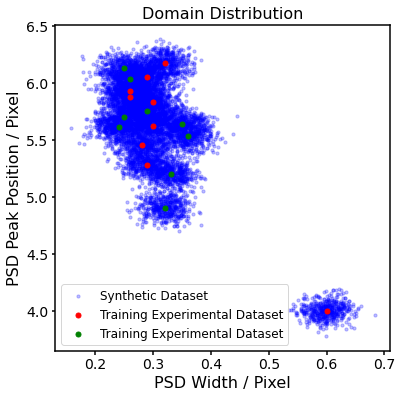

In [262]:
idx = 105
stpara_plot_sim = np.zeros((9000,2))
stpara_plot_exp_train = np.zeros((9,2))
stpara_plot_exp_test = np.zeros((9,2))

# u_sim = np.concatenate(u_sim,axis=0)

for i in range(9000):
    stpara_plot_sim[i,0] = s_sim[i]#np.exp(s_sim[i])/1200*192#
    #np.amin(np.argwhere(cumul_sim[i]<=0.3)) - np.amax(np.argwhere(cumul_sim[i]>=0.7))

#     stpara_plot_sim[i,0] = np.amax(np.argwhere(PSD_sim[i]>=0.5*np.amax(PSD_sim[i])))  - np.amin(np.argwhere(PSD_sim[i]>=0.5*np.amax(PSD_sim[i]))) 
    stpara_plot_sim[i,1] = u_sim[i]# np.exp(u_sim[i])/1200*192# 
    #np.argmax(PSD_sim[i])
    
for i in range(9):
#     stpara_plot_exp[i,0] = np.amax(np.argwhere(PSD_exp[i,0]>=0.5*np.amax(PSD_exp[i,0])))  - np.amin(np.argwhere(PSD_exp[i,0]>=0.5*np.amax(PSD_exp[i,0]))) 

    stpara_plot_exp_train[i,0] = fit_para[2*i,1]#np.exp(fit_para[i,1])/1200*192#np.exp(fit_para[i,1])/1200*192
    stpara_plot_exp_train[i,1] = fit_para[2*i,0]#np.exp(fit_para[i,0])/1200*192#np.exp(fit_para[i,0])/1200*192
    
    stpara_plot_exp_test[i,0] = fit_para[2*i+1,1]#np.exp(fit_para[i,0])/1200*192#np.exp(fit_para[i,0])/1200*192

    stpara_plot_exp_test[i,1] = fit_para[2*i+1,0]#np.exp(fit_para[i,0])/1200*192#np.exp(fit_para[i,0])/1200*192

def plot_TSNE(source, target_train,target_test, title, size, alpha,xmin):
    plt.figure(figsize=(6,6),facecolor='white')
    plt.scatter([i[0] for i in source], [i[1] for i in source], color='blue',marker='o', label = 'Synthetic Dataset', s = 10, alpha = 0.25)
    plt.scatter([i[0] for i in target_train], [i[1] for i in target_train], color='red',marker='o', label = 'Training Experimental Dataset', s = 25, alpha = 0.99)
    plt.scatter([i[0] for i in target_test], [i[1] for i in target_test], color='green',marker='o', label = 'Training Experimental Dataset', s = 25, alpha = 0.99)

    #     plt.scatter(2*[i[0]+1 for i in target], [2*[1]+1 for i in target], color='green',marker='o', label = 'TestingExperimental Dataset', s = 25, alpha = 0.99)

    plt.legend(loc = 'best',prop={'size': 12})
#     plt.xlim(0.18,0.62)
#     plt.ylim(3.9,6.4)
    plt.xlabel('PSD Width / Pixel',fontsize=16)
    plt.ylabel('PSD Peak Position / Pixel',fontsize=16)
    plt.title(title,fontsize=16)
    plt.gca().xaxis.set_tick_params(labelsize=14,width=1.5)
    plt.gca().yaxis.set_tick_params(labelsize=14,width=1.5)


    [x.set_linewidth(1.5) for x in plt.gca().spines.values()]

#     plt.show()
    
plot_TSNE(stpara_plot_sim, stpara_plot_exp_train,stpara_plot_exp_test, 'Domain Distribution', 15, 0.25,0)



In [264]:
#generate calculation images from measured PSDs
auto_expgen = np.zeros((18,50,96,96))

for i in tqdm(range(18)):
    for j in (range(50)):
            #apply the forward operator
        z0 = auto_base_mean#pupil_psd**2#
        z1 = np.abs(np.matmul(H,PSD_exp[i,-1]))**2
        z1 = z1/np.amax(z1)
        auto_expgen[i,j] = z1*z0

  0%|          | 0/18 [00:00<?, ?it/s]

In [265]:
# ##prepare the expermental data with single frame

# # auto_1frame = auto[:,  200:400:4]
# for i in range(auto_50frame.shape[0]):
#     for j in range(auto_50frame.shape[1]):
# #         auto_1frame[i,j] = auto_1frame[i,j] - np.amin(auto_1frame[i,j])

# auto_50frame = auto_50frame[:,:,128-48:128+48, 128-48:128+48]     
# # auto_1frame = auto_1frame[:,:,128-48:128+48, 128-48:128+48]     

auto_1frame = auto[:,  200:400:4]
for i in range(auto_1frame.shape[0]):
    for j in range(auto_1frame.shape[1]):

        auto_1frame[i,j] = auto_1frame[i,j] - np.amin(auto_1frame[i,j])

    
auto_1frame = auto_1frame[:,:,128-48:128+48, 128-48:128+48]     

print(auto_1frame.shape)
print(auto_10frame.shape)


(18, 50, 256, 256)
(18, 50, 96, 96)
(18, 50, 96, 96)


In [266]:


# np.savez('expdata/Pupil_simulation_PSD_cumul_auto10frame-fine powder base_lognormal',
#         PSD_sim = PSD_sim,
#         cumul_sim = cumul_sim,
#         auto_sim = auto_sim,
#         auto_expgen = auto_expgen
#         )



PSD_sim  (9000, 192)
cumul_sim  (9000, 192)
auto_sim  (9000, 96, 96)
auto_expgen  (18, 50, 96, 96)
PSD_exp  (18, 50, 192)
cumul_exp  (18, 50, 192)
auto_exp  (18, 50, 96, 96)


# 5_Neural network training.

In [11]:
data_exp = np.load('expdata/Pupil_18curves_PSD_cumul_auto1frame-fine powder base_betaD.npz')
PSD_exp = data_exp["PSD_exp"] # PSD of the measured data
cumul_exp = data_exp['cumul_exp'] #cumul of the measured data
auto_exp = np.abs(data_exp['auto_exp'].reshape((18,50,1,96,96)))**0.25 #measured 200 frames average-autocorrelation

data_sim = np.load('expdata/Pupil_simulation_PSD_cumul_auto10frame-fine powder base_lognormal.npz')
auto_sim = np.abs(data_sim['auto_sim'].reshape((9000,1,96,96)))**0.25 #calculation from the synthetic data 
PSD_sim = data_sim["PSD_sim"] # PSD of the synthetic data
cumul_sim = data_sim['cumul_sim'] #cumul of the synthetic data
auto_expgen = np.abs(data_sim['auto_expgen'].reshape((18,50,1,96,96)))**0.25 #calculation from the measured PSD


print("PSD_sim ",PSD_sim.shape)
print("cumul_sim ",cumul_sim.shape)
print("auto_sim ",auto_sim.shape)
print("auto_expgen ",auto_expgen.shape)
print("PSD_exp ",PSD_exp.shape)
print("cumul_exp ",cumul_exp.shape)
print("auto_exp ",auto_exp.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'expdata/Pupil_18curves_PSD_cumul_auto1frame-fine powder base_betaD.npz'

603.0


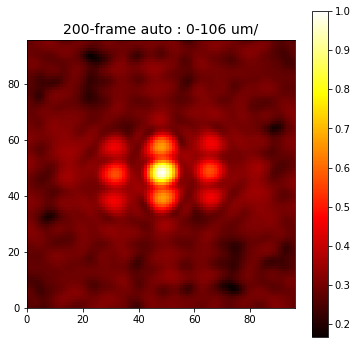

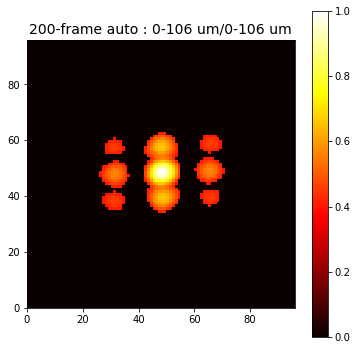

In [5]:
idx_base = 0
idx =0

#plot the 200 avraged autocorrelation
plt.figure(figsize=(6,6))
plt.pcolormesh((auto_exp[idx,0,0]),cmap=plt.cm.hot,
              label = name[1])
plt.colorbar()
# plt.clim(0.,0.002)
plt.gca().set_aspect('equal')
plt.title("200-frame auto : " + name[idx] + '/' ,fontsize=14)


# mask = np.zeros(auto_mean[2].shape)
# mask[auto_mean2[idx_base]>0.015] = 1
# # mask[auto_mean2[idx_base]>0.3] = 0

mask = np.zeros(auto_exp[idx,0,0].shape)
mask[auto_exp[idx,0,0]>0.39] = 1
# mask[auto_mean2[0]**0.5<0.07] = 0

# mask[auto_mean2[4]>0.3] = 0
# for i in range(mask.shape[0]):
#     for j in range(mask.shape[1]):
#         if np.sqrt( (i-mask.shape[0]//2)**2 + (j-mask.shape[1]//2)**2 )>=13.5 and np.sqrt( (i-mask.shape[0]//2)**2 + (j-mask.shape[1]//2)**2 )<=15.5:
#             mask[i,j]=0
#plot the 200 avraged autocorrelation
plt.figure(figsize=(6,6))
plt.pcolormesh((auto_exp[idx,0,0]) *mask ,cmap=plt.cm.hot,
              label = name[1])
plt.colorbar()
# plt.clim(0.,1.)
plt.gca().set_aspect('equal')
plt.title("200-frame auto : " + name[idx] + '/' + name[idx_base],fontsize=14)
print(np.sum(mask))

In [ ]:
# np.savez("mask_for_learning",mask=mask)

In [6]:
#even index sets go to the training set (only train G)
#odd index sets go to the test set

auto_exp_train = np.zeros((9,50,1,96,96))
auto_expgen_train = np.zeros((9,50,1,96,96))
cumul_exp_train = np.zeros((9,50,192))

auto_exp_test = np.zeros((9,50,1,96,96))
auto_expgen_test = np.zeros((9,50,1,96,96))
cumul_exp_test = np.zeros((9,50,192))

for i in range(8):
    auto_exp_train[i] = auto_exp[2*i]*mask
    auto_exp_test[i] = auto_exp[2*i+1]*mask
    
    auto_expgen_train[i] = auto_expgen[2*i ]*mask
    auto_expgen_test[i] = auto_expgen[2*i+1]*mask
    
    cumul_exp_train[i] = cumul_exp[2*i]
    cumul_exp_test[i] = cumul_exp[2*i+1]

auto_exp_train[8] = auto_exp[2*8+1]*mask
auto_exp_test[8] = auto_exp[2*8]*mask

auto_expgen_train[8] = auto_expgen[2*8+1 ]*mask
auto_expgen_test[8] = auto_expgen[2*8 ]*mask

cumul_exp_train[8] = cumul_exp[2*8+1]
cumul_exp_test[8] = cumul_exp[2*8 ]

In [7]:
split_point= 3600
batch_size = 8

############ set sim data ############

###train data
traindata_sim_a = torch.tensor(auto_sim[0:split_point], dtype=torch.float)
traindata_sim_c = torch.tensor(cumul_sim[0:split_point], dtype=torch.float)
#build dataset
trainset_sim = data.TensorDataset(traindata_sim_a,traindata_sim_c)
#load data
train_sim = torch.utils.data.DataLoader(trainset_sim, batch_size = batch_size, shuffle = True)


###test data
valdata_sim_a = torch.tensor(auto_sim[split_point:5000], dtype=torch.float)
valdata_sim_c = torch.tensor(cumul_sim[split_point:5000], dtype=torch.float)
#build dataset
valset_sim = data.TensorDataset(valdata_sim_a, valdata_sim_c)
#load data
val_sim = torch.utils.data.DataLoader(valset_sim, batch_size = batch_size, shuffle = True)

############ set exp data ############

###train data
traindata_exp_a = torch.tensor(np.concatenate(auto_exp_train,axis=0), dtype=torch.float)
traindata_exp_agen = torch.tensor(np.concatenate(auto_expgen_train,axis=0), dtype=torch.float)
traindata_exp_c = torch.tensor(np.concatenate(cumul_exp_train,axis=0), dtype=torch.float)
#build dataset
trainset_exp = data.TensorDataset(traindata_exp_agen,traindata_exp_a,traindata_exp_c)#, traindata_exp_c)
#load data
train_exp = torch.utils.data.DataLoader(trainset_exp, batch_size = batch_size, shuffle = True)



###test data
valdata_exp_agen = torch.tensor(np.concatenate(auto_expgen_test,axis=0), dtype=torch.float)
valdata_exp_a = torch.tensor(np.concatenate(auto_exp_test,axis=0), dtype=torch.float)
valdata_exp_c = torch.tensor(np.concatenate(cumul_exp_test,axis=0), dtype=torch.float)
#build dataset
valset_exp = data.TensorDataset(valdata_exp_agen, valdata_exp_a,valdata_exp_c)
#load data
val_exp = torch.utils.data.DataLoader(valset_exp, batch_size = batch_size, shuffle = True)

In [8]:
class residual_block(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=1,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(residual_block, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.stride_1 = stride_1 #the first block stride, 1 for normal, 2 for downsampling
        self.stride_2 = stride_2 #the second block stride, 1 for normal, 2 for downsampling
        self.dilation = dilation
        self.pad_1 = (2+dilation[0]*(kernel_size[0]-1)-stride_1)//2
        self.pad_2 = (2+dilation[0]*(kernel_size[0]-1)-stride_2)//2
        if activation=='leaky_relu':
            self.a = nn.LeakyReLU()#F.leaky_relu()
        elif activation=='relu':
            self.a = nn.ReLU()#F.relu()
        elif activation=='sigmoid':
            self.a = nn.Sigmoid()
        elif activation=='tanh':
            self.a = nn.Tanh()
        
#         self.bn1 = nn.BatchNorm2d(self.in_filters)
#         self.bn2 = nn.BatchNorm2d(self.out_filters)
        
        self.bn1 = nn.InstanceNorm2d(self.in_filters)
        self.bn2 = nn.InstanceNorm2d(self.out_filters)
        self.conv1 = nn.Conv2d(self.in_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_1, dilation=self.dilation,padding=self.pad_1)
        
        self.conv2 = nn.Conv2d(self.out_filters,self.out_filters, self.kernel_size, 
                               stride=self.stride_2, dilation=self.dilation,padding=self.pad_2)
        
        self.conv3 = nn.Conv2d(self.in_filters,self.out_filters, kernel_size=(1,1), padding=0,
                               stride=self.stride_1,dilation=(1,1))

    def forward(self, x):
        res = self.bn1(x)
        res = self.a(res)
        shortcut = self.conv3(res)
        res = self.conv1(res)
        res = self.bn2(res)
        res = self.a(res)
        res = self.conv2(res)
        res = res+shortcut
        
        return res
    
class down_residual_layer(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(down_residual_layer, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation=self.activation)

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation=self.activation)
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output

    
# class Generator(nn.Module):
#     def __init__(self, fd):
#         super(Generator, self).__init__()
#         self.filters = fd
#         self.pad_1 = (2+1*(3-1)-1)//2
#         self.pad_2 = (2+1*(1-1)-1)//2
        
#         self.residual_block_1 = residual_block(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=1,stride_2=1,activation='relu')

#         self.residual_block_2 = residual_block(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=1,stride_2=1,activation='relu')

#         self.conv1 = nn.Conv2d(2*self.filters[0],self.filters[0], kernel_size=(3,3), 
#                                stride=1, dilation=(1,1),padding=self.pad_1)
#         self.conv2 = nn.Conv2d(self.filters[0],self.filters[0], kernel_size=(1,1), 
#                                stride=1, dilation=(1,1),padding=self.pad_2)
#         self.dropout = nn.Dropout(0.05)

#     def forward(self, x):
# #         n = torch.randn(x.shape).cuda()
# #         n = torch.cat( (x,n),dim=1)
                                           
#         d1 = self.residual_block_1(x)
#         d2 = self.residual_block_2(d1)

#         x = self.conv2(x)
#         x = F.leaky_relu(x)

#         m = torch.cat( (x,d2),dim=1)
#         m = self.conv1(m)

#         output = torch.sigmoid(1* m) #F.leaky_relu(1*m)
#         return output

# class Generator(nn.Module):
#     def __init__(self, fd):
#         super(Generator, self).__init__()
#         self.filters = fd
#         self.pad_1 = (2+1*(3-1)-1)//2
#         self.pad_2 = (2+1*(1-1)-1)//2

#         self.down_residual_layer_1 = down_residual_layer(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    

#     def forward(self, x):
#         return self.down_residual_layer_1(x)

class Generator(nn.Module):
    def __init__(self, in_filters,out_filters, kernel_size=(3,3), stride_1=2,stride_2=1,dilation=(2,2),activation='leaky_relu'):
        super(Generator, self).__init__()
        self.out_filters = out_filters
        self.in_filters = in_filters
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.stride_1 = stride_1
        self.stride_2 = stride_2
        self.activation = activation
        self.residual_block_1 = residual_block(self.in_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=self.stride_1,stride_2=self.stride_2,dilation=(1,1),activation='relu')

        self.residual_block_2 = residual_block(self.out_filters,self.out_filters, kernel_size=self.kernel_size, 
                                               stride_1=1,stride_2=1,dilation=self.dilation, activation='leaky_relu')
        
        self.dropout = nn.Dropout(0.02)
        
    def forward(self, x):
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        output = self.dropout(x)
        return output
                    
                   
class Predictor(nn.Module):
    def __init__(self, fd):
        super(Predictor, self).__init__()
        self.filters = fd
#         self.down_residual_layer_1 = down_residual_layer(self.filters[0],self.filters[1], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.residual_block_2 = residual_block(self.filters[1],self.filters[1], kernel_size=(3,3), 
#                                                stride_1=1,stride_2=1,dilation=(1,1), activation='leaky_relu')
        
#         self.dropout1 = nn.Dropout(0.05)
        self.down_residual_layer_2 = down_residual_layer(self.filters[1],self.filters[2], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)  
        self.down_residual_layer_3 = down_residual_layer(self.filters[2],self.filters[3], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1) 
        self.down_residual_layer_4 = down_residual_layer(self.filters[3],self.filters[4], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    
#         self.down_residual_layer_5 = down_residual_layer(self.filters[4],self.filters[5], kernel_size=(3,3), dilation=(1,1),stride_1=2,stride_2=1)    

        self.bn = nn.InstanceNorm2d(self.filters[4])
#         self.bn = nn.InstanceNorm2d(self.filters[5])

        self.dropout = nn.Dropout(0.02)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(6*6*self.filters[4], 192)   

    def forward(self, x):
#         x = self.residual_block_2(x)
#         x = self.dropout1(x)
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        x = self.down_residual_layer_4(x)
#         x = self.down_residual_layer_5(x)
        x = self.bn(x)
        x = F.leaky_relu(x,negative_slope=0.1)
        x = self.flatten(x)
        x = self.linear1(x)
        output = torch.sigmoid(x)
        return output

#     def first_stage_output(self,x):
#         output = self.down_residual_layer_1(x)
#         return output
    
    def second_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        output = self.down_residual_layer_2(x)
        return output
    
    def third_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        output = self.down_residual_layer_3(x)
        return output
    
    def fourth_stage_output(self,x):
#         x = self.down_residual_layer_1(x)
        x = self.down_residual_layer_2(x)
        x = self.down_residual_layer_3(x)
        output = self.down_residual_layer_4(x)
        return output

In [9]:
# generator = Generator(fd = [1,12, 1])
generator = Generator(1,12)

# generator = Generator(fd = [1,8,16,32,64])
generator.cuda()

predictor = Predictor(fd = [1,12,16,32,64])
# predictor = Predictor(fd = [1,12,32,64,96])
# predictor = Predictor(fd = [1,12,32,64,128, 256])

predictor.cuda()


summary(generator, (1, 96, 96))
summary(predictor, (12, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
    InstanceNorm2d-1            [-1, 1, 96, 96]               0
              ReLU-2            [-1, 1, 96, 96]               0
            Conv2d-3           [-1, 12, 48, 48]              24
            Conv2d-4           [-1, 12, 48, 48]             120
    InstanceNorm2d-5           [-1, 12, 48, 48]               0
              ReLU-6           [-1, 12, 48, 48]               0
            Conv2d-7           [-1, 12, 48, 48]           1,308
    residual_block-8           [-1, 12, 48, 48]               0
    InstanceNorm2d-9           [-1, 12, 48, 48]               0
        LeakyReLU-10           [-1, 12, 48, 48]               0
           Conv2d-11           [-1, 12, 48, 48]             156
           Conv2d-12           [-1, 12, 48, 48]           1,308
   InstanceNorm2d-13           [-1, 12, 48, 48]               0
        LeakyReLU-14           [-1, 12,

In [9]:
def g_loss_npcc2d(generated_image, true_image):
    fsp=generated_image-torch.mean(generated_image,dim=(0,1,2,3),keepdim=True)
    fst=true_image-torch.mean(true_image,dim=(0,1,2,3),keepdim=True)
    
    devP=torch.std(generated_image,dim=(0,1,2,3))
    devT=torch.std(true_image,dim=(0,1,2,3))
    
    npcc_loss=(-1)*torch.mean(fsp*fst,dim=(0,1,2,3))/torch.clamp(devP*devT,1e-10,None)    ## (BL,1)
    return npcc_loss

mask_t = torch.tensor(mask,dtype=torch.float).cuda()


#F training hyperparameters
num_epochs_F = 80
learning_rate_p = 0.002 # learning rate for estimator F
loss_fn_F =  nn.L1Loss() #loss for estimator F
total_params = list(predictor.parameters()) + list(generator.parameters())
p_optimizer = torch.optim.Adam(total_params, lr = learning_rate_p)
p_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(p_optimizer, factor=0.5, patience=6,threshold=0.0002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)

#G training hyperparameters
num_epochs_G = 60
learning_rate_g = 0.002 # learning rate for generator G
loss_fn_G = nn.L1Loss()#g_loss_npcc2d  #nn.L1Loss()#loss for generator G
g_optimizer = torch.optim.Adam(generator.parameters(), lr = learning_rate_g)
g_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(g_optimizer, factor=0.5, patience=6,threshold=0.002,
                                                       threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)


In [10]:

#training loss
Loss_cycle = []

#validation with exp data
Val_Loss_F = []

#validation with sim data
Val_Loss_Cycle = []


pbar = tqdm(range(num_epochs_F))

for epoch in pbar:
    
    ######## training process ########
    sim_iter = iter(train_sim)
    exp_iter = iter(train_exp)

    times = min(len(train_sim), len(train_exp))
    start_time = time.time()
    for i in range(times):
        
        sim_a, sim_c = sim_iter.next()
        sim_a = sim_a.cuda()
        sim_c = sim_c.cuda()

        ############################
        # (1) Update F network: minimize L1(f - F(G(gi)) )
        ###########################
        p_optimizer.zero_grad()

        output_c = predictor( ( generator(sim_a) ) )
        errCycle = loss_fn_F(output_c, sim_c) 
        errF = errCycle
        Loss_cycle.append(errCycle.item())
                
        errF.backward()
        p_optimizer.step()

        ############################
        # (2) check the training loss
        ###########################
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\t Training_Loss: %.4f \t%.4f s'
                  % (epoch, num_epochs_F, i, times,
                    errCycle.item(), time.time()-start_time))
            start_time = time.time()


    ############### test set exp ################
    exp_iter = iter(val_exp)
    valloss_F = 0
    times = len(val_exp)
    with torch.no_grad():
        for i in range(times):
    
            exp_agen, exp_a,exp_c = exp_iter.next()
            exp_agen = exp_agen.cuda()
            exp_a = exp_a.cuda()
            exp_c = exp_c.cuda()

            predicted_c = predictor(generator(exp_a ))#, lambda_)
            err_valF = loss_fn_F(predicted_c,exp_c)
            valloss_F += err_valF.mean().item()
            
    Val_Loss_F.append(valloss_F/times)

    ############### test set sim ################
    sim_iter = iter(val_sim)
    valloss_Cycle = 0
    times = len(val_sim)
    with torch.no_grad():

        for i in range(times):
    
            sim_a,sim_c = sim_iter.next()
            sim_a = sim_a.cuda()
            sim_c = sim_c.cuda()

            predicted_c = predictor((generator(sim_a)) )#, lambda_)
            err_valCycle = loss_fn_F(predicted_c,sim_c)
            valloss_Cycle += err_valCycle.mean().item()
        Val_Loss_Cycle.append(valloss_Cycle/times)
    p_scheduler.step(Val_Loss_F[-1])

    print("Val: Epoch: %d | exp_estimator_Loss: %f| sim_estimator_Loss: %f" %(epoch + 1, 
                                                                      Val_Loss_F[-1],
                                                                      Val_Loss_Cycle[-1]))

  0%|          | 0/80 [00:00<?, ?it/s]

[0/80][0/57]	 Training_Loss: 0.4437 	0.0231 s
[0/80][20/57]	 Training_Loss: 0.0656 	0.2034 s
[0/80][40/57]	 Training_Loss: 0.0565 	0.2000 s
Val: Epoch: 1 | exp_estimator_Loss: 0.072070| sim_estimator_Loss: 0.045519
[1/80][0/57]	 Training_Loss: 0.0418 	0.0112 s
[1/80][20/57]	 Training_Loss: 0.0434 	0.1995 s
[1/80][40/57]	 Training_Loss: 0.0357 	0.1990 s
Val: Epoch: 2 | exp_estimator_Loss: 0.093458| sim_estimator_Loss: 0.020533
[2/80][0/57]	 Training_Loss: 0.0400 	0.0115 s
[2/80][20/57]	 Training_Loss: 0.0366 	0.2048 s
[2/80][40/57]	 Training_Loss: 0.0303 	0.2032 s
Val: Epoch: 3 | exp_estimator_Loss: 0.105672| sim_estimator_Loss: 0.041946
[3/80][0/57]	 Training_Loss: 0.0374 	0.0113 s
[3/80][20/57]	 Training_Loss: 0.0408 	0.2004 s
[3/80][40/57]	 Training_Loss: 0.0280 	0.2014 s
Val: Epoch: 4 | exp_estimator_Loss: 0.128921| sim_estimator_Loss: 0.016430
[4/80][0/57]	 Training_Loss: 0.0281 	0.0115 s
[4/80][20/57]	 Training_Loss: 0.0303 	0.1984 s
[4/80][40/57]	 Training_Loss: 0.0382 	0.2016 s


[36/80][20/57]	 Training_Loss: 0.0078 	0.1972 s
[36/80][40/57]	 Training_Loss: 0.0065 	0.1979 s
Val: Epoch: 37 | exp_estimator_Loss: 0.132857| sim_estimator_Loss: 0.008187
[37/80][0/57]	 Training_Loss: 0.0095 	0.0109 s
[37/80][20/57]	 Training_Loss: 0.0058 	0.1974 s
[37/80][40/57]	 Training_Loss: 0.0110 	0.1978 s
Val: Epoch: 38 | exp_estimator_Loss: 0.132543| sim_estimator_Loss: 0.007096
[38/80][0/57]	 Training_Loss: 0.0085 	0.0110 s
[38/80][20/57]	 Training_Loss: 0.0056 	0.1983 s
[38/80][40/57]	 Training_Loss: 0.0103 	0.1976 s
Val: Epoch: 39 | exp_estimator_Loss: 0.132773| sim_estimator_Loss: 0.007716
[39/80][0/57]	 Training_Loss: 0.0076 	0.0106 s
[39/80][20/57]	 Training_Loss: 0.0097 	0.1973 s
[39/80][40/57]	 Training_Loss: 0.0066 	0.1989 s
Val: Epoch: 40 | exp_estimator_Loss: 0.136499| sim_estimator_Loss: 0.007165
[40/80][0/57]	 Training_Loss: 0.0068 	0.0111 s
[40/80][20/57]	 Training_Loss: 0.0096 	0.2016 s
[40/80][40/57]	 Training_Loss: 0.0105 	0.1969 s
Val: Epoch: 41 | exp_estimat

[72/80][20/57]	 Training_Loss: 0.0062 	0.1989 s
[72/80][40/57]	 Training_Loss: 0.0062 	0.1970 s
Val: Epoch: 73 | exp_estimator_Loss: 0.137814| sim_estimator_Loss: 0.006967
[73/80][0/57]	 Training_Loss: 0.0052 	0.0110 s
[73/80][20/57]	 Training_Loss: 0.0049 	0.2012 s
[73/80][40/57]	 Training_Loss: 0.0114 	0.2002 s
Val: Epoch: 74 | exp_estimator_Loss: 0.136747| sim_estimator_Loss: 0.007241
[74/80][0/57]	 Training_Loss: 0.0050 	0.0113 s
[74/80][20/57]	 Training_Loss: 0.0098 	0.2042 s
[74/80][40/57]	 Training_Loss: 0.0110 	0.2018 s
Val: Epoch: 75 | exp_estimator_Loss: 0.136796| sim_estimator_Loss: 0.007133
[75/80][0/57]	 Training_Loss: 0.0070 	0.0112 s
[75/80][20/57]	 Training_Loss: 0.0044 	0.2024 s
[75/80][40/57]	 Training_Loss: 0.0086 	0.1994 s
Val: Epoch: 76 | exp_estimator_Loss: 0.138930| sim_estimator_Loss: 0.006906
[76/80][0/57]	 Training_Loss: 0.0081 	0.0112 s
[76/80][20/57]	 Training_Loss: 0.0073 	0.2046 s
[76/80][40/57]	 Training_Loss: 0.0047 	0.2018 s
Val: Epoch: 77 | exp_estimat

In [11]:
#Estimator training
predictor.train()
#validation with exp data
Val_Loss_G = []

pbar = tqdm(range(num_epochs_G))

for epoch in pbar:
    
    ######## training process ########
    exp_iter = iter(train_exp)
    
    times = len(train_exp)
    start_time = time.time()
    for i in range(times):

        exp_agen, exp_a, exp_c = exp_iter.next()

        exp_a = exp_a.cuda()
        exp_agen = exp_agen.cuda()
        exp_c = exp_c.cuda()

        ############################
        # (1) Update G network
        ##########################
        g_optimizer.zero_grad()
        output_c = predictor( ( generator(exp_a) ) )
        errCond = loss_fn_F(output_c, exp_c) 
        errG =    errCond 
        Loss_cycle.append(errCycle.item())
                
        errG.backward()
        g_optimizer.step()

        ############################
        # (2) check the training loss
        ###########################
        if i % 20 == 0:
            print('[%d/%d][%d/%d]\t G_Loss: %.4f \t%.4f s'
                  % (epoch, num_epochs_G, i, times,
                    errG.item(), time.time()-start_time))
            start_time = time.time()


    ############### validation set ################
    exp_iter = iter(val_exp)
    valloss_G = 0
    times = len(val_exp)
    with torch.no_grad():
        for i in range(times):
    
            exp_agen, exp_a, exp_c = exp_iter.next()
            exp_agen = exp_agen.cuda()
            exp_a = exp_a.cuda()
            exp_c = exp_c.cuda()

            generated_c = predictor(generator(exp_a))
            err_valG = loss_fn_F(generated_c,exp_c)#* 96**2/541
            valloss_G += err_valG.mean().item()
            
    Val_Loss_G.append(valloss_G/times)
    g_scheduler.step(Val_Loss_G[-1])


    print("Val: Epoch: %d | generator_loss: %f" %(epoch + 1, Val_Loss_G[-1] ))

  0%|          | 0/60 [00:00<?, ?it/s]

[0/60][0/57]	 G_Loss: 0.1562 	0.0091 s
[0/60][20/57]	 G_Loss: 0.0984 	0.1597 s
[0/60][40/57]	 G_Loss: 0.1092 	0.1557 s
Val: Epoch: 1 | generator_loss: 0.056681
[1/60][0/57]	 G_Loss: 0.0595 	0.0084 s
[1/60][20/57]	 G_Loss: 0.0639 	0.1566 s
[1/60][40/57]	 G_Loss: 0.0495 	0.1541 s
Val: Epoch: 2 | generator_loss: 0.049840
[2/60][0/57]	 G_Loss: 0.0492 	0.0083 s
[2/60][20/57]	 G_Loss: 0.0392 	0.1584 s
[2/60][40/57]	 G_Loss: 0.0641 	0.1577 s
Val: Epoch: 3 | generator_loss: 0.039101
[3/60][0/57]	 G_Loss: 0.0410 	0.0082 s
[3/60][20/57]	 G_Loss: 0.0660 	0.1586 s
[3/60][40/57]	 G_Loss: 0.0696 	0.1583 s
Val: Epoch: 4 | generator_loss: 0.040559
[4/60][0/57]	 G_Loss: 0.0347 	0.0085 s
[4/60][20/57]	 G_Loss: 0.0410 	0.1592 s
[4/60][40/57]	 G_Loss: 0.0469 	0.1570 s
Val: Epoch: 5 | generator_loss: 0.036480
[5/60][0/57]	 G_Loss: 0.0516 	0.0083 s
[5/60][20/57]	 G_Loss: 0.0528 	0.1589 s
[5/60][40/57]	 G_Loss: 0.0418 	0.1584 s
Val: Epoch: 6 | generator_loss: 0.038076
[6/60][0/57]	 G_Loss: 0.0236 	0.0085 s
[

[49/60][40/57]	 G_Loss: 0.0207 	0.1584 s
Epoch 00050: reducing learning rate of group 0 to 1.2500e-04.
Val: Epoch: 50 | generator_loss: 0.025898
[50/60][0/57]	 G_Loss: 0.0198 	0.0084 s
[50/60][20/57]	 G_Loss: 0.0208 	0.1584 s
[50/60][40/57]	 G_Loss: 0.0324 	0.1568 s
Val: Epoch: 51 | generator_loss: 0.026704
[51/60][0/57]	 G_Loss: 0.0205 	0.0082 s
[51/60][20/57]	 G_Loss: 0.0143 	0.1552 s
[51/60][40/57]	 G_Loss: 0.0188 	0.1544 s
Val: Epoch: 52 | generator_loss: 0.025920
[52/60][0/57]	 G_Loss: 0.0173 	0.0084 s
[52/60][20/57]	 G_Loss: 0.0167 	0.1574 s
[52/60][40/57]	 G_Loss: 0.0195 	0.1551 s
Val: Epoch: 53 | generator_loss: 0.029588
[53/60][0/57]	 G_Loss: 0.0202 	0.0084 s
[53/60][20/57]	 G_Loss: 0.0295 	0.1558 s
[53/60][40/57]	 G_Loss: 0.0180 	0.1554 s
Val: Epoch: 54 | generator_loss: 0.028555
[54/60][0/57]	 G_Loss: 0.0206 	0.0081 s
[54/60][20/57]	 G_Loss: 0.0193 	0.1553 s
[54/60][40/57]	 G_Loss: 0.0155 	0.1558 s
Val: Epoch: 55 | generator_loss: 0.026356
[55/60][0/57]	 G_Loss: 0.0193 	0.00

In [12]:

# # predictor = Predictor(fd = [1,8,16,32,64])
# # # predictor = Predictor(fd = [1,16,32,64,96])

# # predictor.cuda()
# # generator.train()
# #F training hyperparameters
# num_epochs_F = 30
# learning_rate_p = 0.0002 # learning rate for estimator F
# loss_fn_F =  nn.L1Loss() #loss for estimator F
# p_optimizer = torch.optim.Adam(predictor.parameters(), lr = learning_rate_p)
# p_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(p_optimizer, factor=0.5, patience=4,threshold=0.002,
#                                                        threshold_mode='abs', min_lr=1e-7, eps=1e-08, verbose=True)

[None, None, None, None]

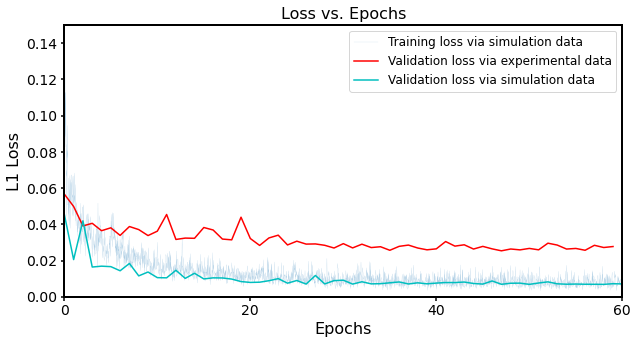

In [13]:
plt.figure(figsize=(10,5))
plt.title("Loss vs. Epochs",fontsize=16)
plt.plot((np.arange(len(Loss_cycle))+1)/50,Loss_cycle, alpha=0.7,
         linewidth=0.1, label='Training loss via simulation data')
plt.plot(Val_Loss_G, 'r-',label='Validation loss via experimental data')
plt.plot(Val_Loss_Cycle,'c-', label='Validation loss via simulation data')
plt.ylim(0,0.15)
plt.legend()
plt.xlim(0,60)
plt.xticks([0,20,40,60])
plt.legend(prop={'size': 12})
plt.gca().xaxis.set_tick_params(labelsize=14,width=1.5)
plt.gca().yaxis.set_tick_params(labelsize=14,width=1.5)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('L1 Loss',fontsize=16)
[x.set_linewidth(2) for x in plt.gca().spines.values()]

  0%|          | 0/18 [00:00<?, ?it/s]

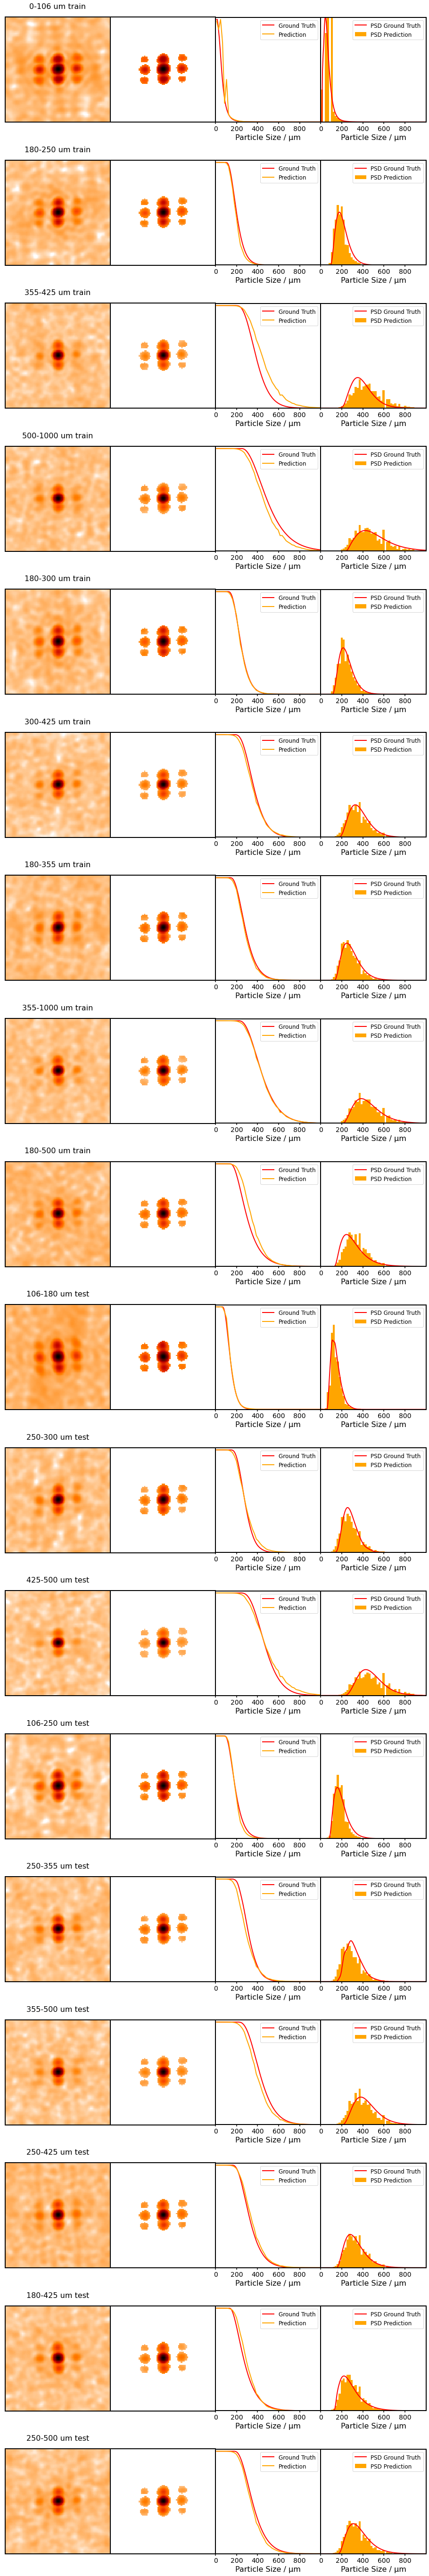

In [11]:
predictor.eval()
generator.eval()
fileidx = 16
auto_expgen_t = torch.tensor(auto_expgen, dtype=torch.float).cuda()
auto_exp_t = torch.tensor(auto_exp, dtype=torch.float).cuda()
cumul_exp_t = torch.tensor(cumul_exp).to('cuda')
mask_t = torch.tensor(mask,dtype=torch.float).cuda()


auto_predict_expgen_plot = np.zeros((18,96,96))
#average reduce the cumul predict to 64
cumul_predict_plot_r = np.zeros((18,192//3))
cumul_predict_plot = np.zeros((18,192))

pred_PSD = np.zeros((18,cumul_predict_plot_r.shape[-1]-1))
pred_PSD_d = np.zeros((18,cumul_predict_plot.shape[-1]-1))
for i in tqdm(range(18)):
    #predict generalized auto_expgen
#     auto_predict_expgen_plot[i] = generator(auto_expgen_t[i,0:1]).reshape((96,96)).cpu().detach().numpy()
#     auto_predict_expgen_plot[i] = (auto_predict_expgen_plot[i]) 

    cumul_predict_plot[i] = predictor(generator(auto_exp_t[i,1:2]*mask_t)).reshape(192).cpu().detach().numpy()
    cumul_predict_plot[i] = normalize(cumul_predict_plot[i])#

    cumul_predict_plot_r[i] = rebin1d(cumul_predict_plot[i],(64))
    pred_PSD[i] = -(cumul_predict_plot_r[i] - np.roll(cumul_predict_plot_r[i],1))[1:64]
    pred_PSD[i] = pred_PSD[i]/np.sum(pred_PSD[i])/3
    pred_PSD[i,pred_PSD[i]<0]=0
    
    pred_PSD_d[i] = -(cumul_predict_plot[i] - np.roll(cumul_predict_plot[i],1))[1:192]
    pred_PSD_d[i] = pred_PSD_d[i]/np.sum(pred_PSD_d[i])/3
    pred_PSD_d[i,pred_PSD_d[i]<0]=0
    
    
x_new_r = np.linspace(10, 1200, num=64, endpoint=True)
x_new = np.linspace(10, 1200, num=192, endpoint=True)

    
fig, axs = plt.subplots(18,4, figsize=(4*4, 5*20), facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = 0.1, wspace=.001)
idx = np.array([0,2,4,6,8,10,12,14,17,
               1,3,5,7,9,11,13,15,16])
for j in range(18):
    i = int(idx[j])
    axs[j,0].pcolormesh(((auto_exp[i,0].reshape((96,96)))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,0].set_aspect('equal')
    if i in [0,2,4,6,8,10,12,14,17]:
        axs[j,0].set_title(name[i] +" train", y=1, pad=18 ,color='k',fontsize=16)
    elif i in [1,3,5,7,9,11,13,15,16]:
        axs[j,0].set_title(name[i]+' test', y=1, pad=18 ,color='k',fontsize=16)

    axs[j,0].set_xticks([])
    axs[j,0].set_yticks([])
    [x.set_linewidth(2) for x in axs[j,0].spines.values()]
    
#     axs[j,1].pcolormesh((auto_predict_expgen_plot[i].reshape((96,96))),vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
#     axs[j,1].set_aspect('equal')
#     axs[j,1].set_yticks([])
#     axs[j,1].set_xticks([])
#     [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,1].pcolormesh(((auto_exp[i,0].reshape((96,96))))*mask,vmax=1,vmin=0.18,cmap=plt.cm.gist_heat_r)
    axs[j,1].set_aspect('equal')
    axs[j,1].set_yticks([])
    axs[j,1].set_xticks([])
    [x.set_linewidth(2) for x in axs[j,1].spines.values()]

    axs[j,2].plot(x_new,cumul_exp[i,0],'r-',linewidth=2, label='Ground Truth')
    axs[j,2].plot(x_new_r, cumul_predict_plot_r[i],color='orange',linewidth=2, label='Prediction')
    axs[j,2].legend(prop={'size': 12})
    axs[j,2].set_aspect(995/1.02)
    axs[j,2].set_xlim(0,1000)
    axs[j,2].set_ylim(0.,1.02)
    axs[j,2].set_yticks([])
    axs[j,2].set_xticks([0,200,400,600,800])
    axs[j,2].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,2].xaxis.set_tick_params(labelsize=14,width=1.5)
    [x.set_linewidth(2) for x in axs[j,2].spines.values()]

    axs[j,3].bar(x_new_r[0:-1], pred_PSD[i], width=20, fill=True, 
                 color='orange',label='PSD Prediction')
    axs[j,3].plot(x_new, PSD_exp[i,0],color='r',linewidth=2,label='PSD Ground Truth')
    axs[j,3].legend(prop={'size': 12})
    axs[j,3].set_xlim(0,1000)
    axs[j,3].set_ylim(0,0.09)
    axs[j,3].set_yticks([])
    axs[j,3].set_xticks([0,200,400,600,800])
    axs[j,3].xaxis.set_tick_params(labelsize=14,width=1.5)
    axs[j,3].set_xlabel('Particle Size / μm',fontsize=16)
    axs[j,3].set_aspect(995/0.09)
    [x.set_linewidth(2) for x in axs[j,3].spines.values()]

In [10]:
# model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_generator_1.pt'
# torch.save(generator, model_path)
# model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_predictor_1.pt'
# torch.save(predictor, model_path)


# np.savez('Domain transfer-1 frames-fine powder base-lognormal_mask_1',
#          Loss_cycle=Loss_cycle,
#          Val_Loss_G = Val_Loss_G,
#          Val_Loss_F = Val_Loss_F,
#          Val_Loss_Cycle = Val_Loss_Cycle
#         )

# model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_generator_1.pt'
# torch.save(generator, model_path)
# model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_predictor_1.pt'
# torch.save(predictor, model_path)

model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_generator_1.pt'
generator = torch.load(model_path)
generator.eval()
generator.cuda()
model_path = 'Domain transfer-1 frames-fine powder base-lognormal_mask_predictor_1.pt'
predictor = torch.load(model_path)
predictor.eval()
predictor.cuda()

Predictor(
  (down_residual_layer_2): down_residual_layer(
    (residual_block_1): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(12, 16, kernel_size=(1, 1), stride=(2, 2))
    )
    (residual_block_2): residual_block(
      (a): LeakyReLU(negative_slope=0.01)
      (bn1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (bn2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddin